In [1]:
import numpy as np

import torch
from torch import nn
from torch import functional as F

from livelossplot import PlotLosses

import matplotlib.pyplot as plt
plt.style.use('ggplot')

In [2]:
from Inference import BBVI 

In [3]:
from Inference.BBVI import VariationalNetwork

In [4]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda', index=0)

In [5]:
sigma_noise = 0.1
data = torch.load('Data/foong_data.pt')
x_data = data[0].to(device)
y_data = data[1].to(device)
y_data = y_data.unsqueeze(-1)

In [101]:
class MixtureVariationalNetwork(nn.Module):
    def __init__(self, input_size, output_size, layer_width, nb_layers, device=None):
        super(MixtureVariationalNetwork, self).__init__()
        
        self.layer_width = layer_width
        self.input_size = input_size
        self.output_size = output_size
        self.nb_layers = nb_layers
        self.device = device
        
        self.components = []
        self.pi = torch.tensor([], device=device)
        
    def add_component(self, component, proportion):
        #todo check compatibility with other components
        component.requires_grad_rhos(False)
        component.requires_grad_mus(False)
        self.components.append(component)
        proportion = proportion.to(self.device)
        self.pi = torch.cat((self.pi*(1-proportion), proportion.unsqueeze(0)))
        self.pi.require_grad = False
        
    def sample_parameters(self, M=1, new_component=None, new_proportion=torch.tensor(0.0)):
        npi = torch.tensor([1.0-new_proportion, new_proportion], device=self.device)
        D = torch.distributions.multinomial.Multinomial(M, npi)
        m_oldnew = D.sample()
        if int(m_oldnew[0]) > 0:
            D_old = torch.distributions.multinomial.Multinomial(int(m_oldnew[0]), self.pi)
            m_old = D_old.sample()
        else:
            m_old = torch.zeros(self.pi.size())

        S = []    
        for j in range(len(self.pi)):
            t = self.components[j].sample_parameters(int(m_old[j]))
            if int(m_old[j]) > 0: 
                S.append(t)
        if new_component is not None:
            S.append(new_component.sample_parameters(int(m_oldnew[1])))

        return ([torch.cat([c[0][k] for c in S]) for k in range(self.nb_layers)], [torch.cat([c[1][k] for c in S]) for k in range(self.nb_layers)])

    def q_log_pdf(self, layered_w_samples, layered_bias_samples):
        log_q = [c.q_log_pdf(layered_w_samples, layered_bias_samples) for c in self.components]
        return torch.logsumexp(torch.stack(log_q) + torch.log(self.pi).unsqueeze(0).t(), dim=0)

    def prior_log_pdf(self, layered_w_samples, layered_bias_samples):
        log_prior = [c.prior_log_pdf(layered_w_samples, layered_bias_samples) for c in self.components]
        return torch.logsumexp(torch.stack(log_prior) + torch.log(self.pi).unsqueeze(0).t(), dim=0)
    
    def full_elbo(self, x_data, y_data, n_samples_ELBO, sigma_noise, new_component=None, new_proportion=None):
        (layered_w_samples_XC, layered_bias_samples_XC) = self.sample_parameters(n_samples_ELBO, new_component, new_proportion)

        logprior_XC = self.prior_log_pdf(layered_w_samples_XC, layered_bias_samples_XC)

        if new_component is None:
            y_pred_XC = self.forward(x_data)
        else:
            y_pred_XC = torch.cat([self.forward(x_data), new_component.forward(x_data)], dim=0)
            
        loglikelihood_XC = self._log_norm(y_pred_XC, y_data, torch.tensor(sigma_noise).to(self.device))

        logposterior_XC = (logprior_XC.unsqueeze(-1).unsqueeze(-1).repeat([1,x_data.shape[0],1]) + loglikelihood_XC).sum(dim=[1,2])

        logq_XC = self.q_log_pdf(layered_w_samples_XC, layered_bias_samples_XC)

        logqnew_XC = new_component.q_log_pdf(layered_w_samples_XC, layered_bias_samples_XC)

        logqall_XC = torch.exp(torch.logsumexp( \
        torch.stack([torch.log(torch.tensor(1.0, device=self.device)-new_proportion) + logq_XC, \
                    torch.log(new_proportion) + logqnew_XC], dim=0), dim=0))

        return (logposterior_XC - logqall_XC).sum()
        
    def compute_elbo_backup(self, x_data, y_data, n_samples_ELBO, sigma_noise, new_component=None, new_proportion=None):
        # sample X^(c)
        (layered_w_samples_XC, layered_bias_samples_XC) = self.sample_parameters(n_samples_ELBO)

        LP_XC = self.prior_log_pdf(layered_w_samples_XC, layered_bias_samples_XC)
        y_pred_XC = self.forward(x_data)
        LL_XC = self._log_norm(y_pred_XC, y_data, torch.tensor(sigma_noise).to(self.device))
        posterior_XC = (LP_XC.unsqueeze(-1).unsqueeze(-1).repeat([1,x_data.shape[0],1]) + LL_XC).sum(dim=[1,2])

        qC_log_XC = self.q_log_pdf(layered_w_samples_XC, layered_bias_samples_XC)

        qN_log_XC = new_component.q_log_pdf(layered_w_samples_XC, layered_bias_samples_XC)
        qN_log_XC.shape

        qCN_log_XC = torch.logsumexp(torch.stack([torch.log(torch.tensor(1.0, device=self.device)-new_proportion) + qC_log_XC, torch.log(new_proportion) + qN_log_XC],dim=0),dim=0)
        qCN_log_XC.shape

        # sample X_(c+1)
        (layered_w_samples_XN, layered_bias_samples_XN) = new_component.sample_parameters(n_samples_ELBO)

        LP_XN = new_component.prior_log_pdf(layered_w_samples_XN, layered_bias_samples_XN)
        y_pred_XN = new_component.forward(x_data)
        LL_XN = new_component._log_norm(y_pred_XN, y_data, torch.tensor(sigma_noise).to(self.device))
        posterior_XN = (LP_XN.unsqueeze(-1).unsqueeze(-1).repeat([1,x_data.shape[0],1]) + LL_XN).sum(dim=[1,2])

        qC_log_XN = self.q_log_pdf(layered_w_samples_XN, layered_bias_samples_XN)

        qN_log_XN = new_component.q_log_pdf(layered_w_samples_XN, layered_bias_samples_XN)
        qCN_log_XN = torch.logsumexp(torch.stack([torch.log(torch.tensor(1.0, device=self.device)-new_proportion) + qC_log_XN, torch.log(new_proportion) + qN_log_XN],dim=0),dim=0)

        L = (torch.tensor(1.0, device=self.device)-new_proportion) * (posterior_XC.mean() - qCN_log_XC.mean()) + new_proportion * (posterior_XN.mean() - qCN_log_XN.mean()) 

        return L
    
    def compute_elbo(self, x_data, y_data, n_samples_ELBO, sigma_noise, new_component=None, new_proportion=None):
        # sample X^(c)
        (layered_w_samples_XC, layered_bias_samples_XC) = self.sample_parameters(n_samples_ELBO)

        LP_XC = self.prior_log_pdf(layered_w_samples_XC, layered_bias_samples_XC)
        y_pred_XC = self.forward(x_data)
        LL_XC = self._log_norm(y_pred_XC, y_data, torch.tensor(sigma_noise).to(self.device))
        posterior_XC = LL_XC.sum(dim=[1,2]) + LP_XC

        qC_log_XC = self.q_log_pdf(layered_w_samples_XC, layered_bias_samples_XC)

        qN_log_XC = new_component.q_log_pdf(layered_w_samples_XC, layered_bias_samples_XC)

        qCN_log_XC = torch.logsumexp(torch.stack([torch.log(torch.tensor(1.0, device=self.device)-new_proportion) + qC_log_XC, torch.log(new_proportion) + qN_log_XC],dim=0),dim=0)

        # sample X_(c+1)
        (layered_w_samples_XN, layered_bias_samples_XN) = new_component.sample_parameters(n_samples_ELBO)

        LP_XN = new_component.prior_log_pdf(layered_w_samples_XN, layered_bias_samples_XN)
        y_pred_XN = new_component.forward(x_data)
        LL_XN = new_component._log_norm(y_pred_XN, y_data, torch.tensor(sigma_noise).to(self.device))
        posterior_XN = LL_XN.sum(dim=[1,2]) + LP_XN

        qC_log_XN = self.q_log_pdf(layered_w_samples_XN, layered_bias_samples_XN)

        qN_log_XN = new_component.q_log_pdf(layered_w_samples_XN, layered_bias_samples_XN)
        qCN_log_XN = torch.logsumexp(torch.stack([torch.log(torch.tensor(1.0, device=self.device)-new_proportion) + qC_log_XN, \
                torch.log(new_proportion) + qN_log_XN],dim=0),dim=0)

        L = (torch.tensor(1.0, device=self.device)-new_proportion) * (posterior_XC.mean() - qCN_log_XC.mean()) + new_proportion * (posterior_XN.mean() - qCN_log_XN.mean()) 
        #L = new_proportion*(posterior_XN.mean() - qCN_log_XN.mean())
        return -L
    
    def requires_grad_rhos(self, v = False):
        for k in range(len(self.components)):
            self.components[k].requires_grad_rhos(v)
        
    def requires_grad_mus(self, v = False):
        for k in range(len(self.components)):
            self.components[k].requires_grad_mus(v)
    
    def forward(self, x):
        return torch.cat([self.components[k].forward(x) for k in range(len(self.components))],dim=0)
    

    def _log_norm(self, x, mu, std):
        return -0.5 * torch.log(2*np.pi*std**2) -(0.5 * (1/(std**2))* (x-mu)**2)

In [24]:
class VariationalBoostingOptimizer():
    def __init__(self, mixture, sigma_noise, optimizer, optimizer_params, scheduler=None, scheduler_params=None):
        self.mixture = mixture
        self.sigma_noise = sigma_noise
        self.device = model.device
        
        self.optimizer = optimizer
        if scheduler is None:           
            self.scheduler = None
        else:
            self.scheduler = scheduler
            
    def run(self, data, n_epoch=100, n_iter=1, n_ELBO_samples=1, seed=None, plot=False, savePath=None, xpName=None, networkName=None, saveName=None):
        if seed is not None:
            torch.manual_seed(seed)
            np.random.seed(seed)

        x_data = data[0].to(self.device)
        y_data = data[1].to(self.device)

        self.optimizer.zero_grad()

        if saveName is not None and savePath is not None:
            liveloss = PlotLosses(fig_path=str(savePath)+str(xpName)+'_'+str(networkName)+'_'+str(saveName))
        else:
            liveloss = PlotLosses()

        for j in range(n_epoch):
            logs = {}
            losses = [None] * n_iter

            for k in range(n_iter):
                self.optimizer.zero_grad()
                loss = self.model.compute_elbo(x_data, y_data, n_ELBO_samples, self.sigma_noise, self.device)
                losses[k] = loss
                loss.backward()
                self.optimizer.step()

            logs['expected_loss'] = torch.stack(losses).mean().detach().clone().cpu().numpy()
            logs['learning rate'] = self.optimizer.param_groups[0]['lr']
            liveloss.update(logs)
            if plot is True:
                liveloss.draw()
            if self.scheduler is not None:
                self.scheduler.step(logs['expected_loss'])
        return self.model

In [69]:
c1 = VariationalNetwork(1, 1, 20, 2, device=device)

In [74]:
optimizer = torch.optim.Adam
optimizer_params = {'lr': 0.5}

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau
scheduler_params = {'patience': 3, 'factor': 0.8}

In [75]:
voptimizer = BBVI.VariationalOptimizer(model=c1, sigma_noise=0.1, optimizer=optimizer, optimizer_params=optimizer_params, scheduler=scheduler, scheduler_params=scheduler_params)

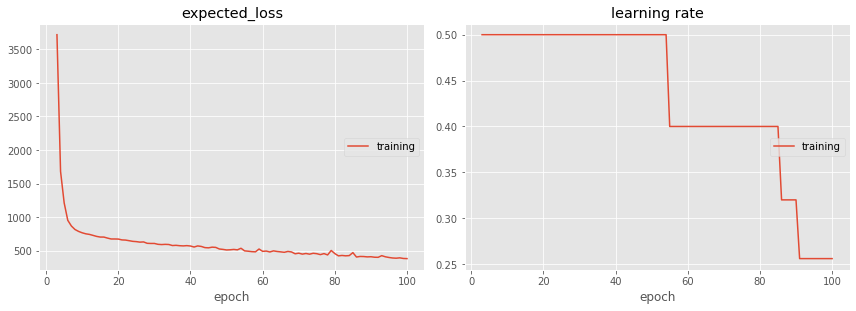

expected_loss:
training   (min:  380.836, max: 195576.219, cur:  380.836)

learning rate:
training   (min:    0.256, max:    0.500, cur:    0.256)


In [76]:
c1 = voptimizer.run((x_data,y_data), n_epoch=100, n_iter=20, n_ELBO_samples=25, plot=True)

In [102]:
mix = MixtureVariationalNetwork(1, 1, 20, 2, device=device)

In [103]:
mix.add_component(c1, torch.tensor(1.0))

In [79]:
new_component = VariationalNetwork(1, 1, 20, 2, device=device)

In [80]:
new_unscaled_proportion = nn.Parameter(torch.tensor(0.0, requires_grad=False, device=device), requires_grad =False)
with torch.no_grad():
    new_proportion = torch.sigmoid(new_unscaled_proportion)

In [81]:
new_proportion

tensor(0.5000, device='cuda:0')

In [82]:
optimizer = torch.optim.Adam
optimizer_params = {'lr': 0.5}

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau
scheduler_params = {'patience': 2, 'factor': 0.8}

In [83]:
parameters = list(new_component.parameters())

In [84]:
vo = optimizer(parameters, **optimizer_params)

In [85]:
s = scheduler(vo, **scheduler_params)

In [86]:
n_iter = 20
n_epoch = 30
liveloss = PlotLosses()
plot = True

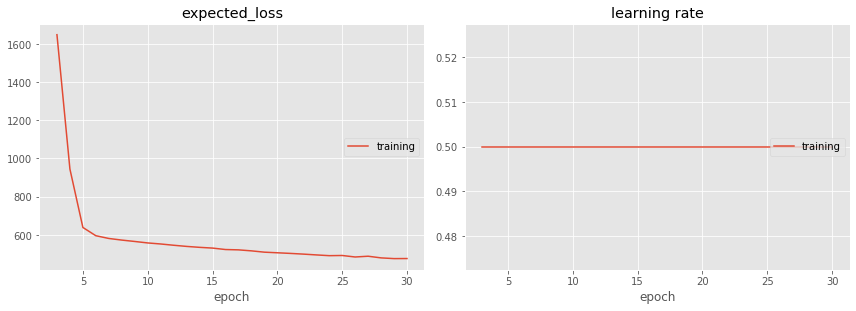

expected_loss:
training   (min:  475.715, max: 70897.203, cur:  476.035)

learning rate:
training   (min:    0.500, max:    0.500, cur:    0.500)


In [87]:
for j in range(n_epoch):
    logs = {}
    losses = [None] * n_iter

    for k in range(n_iter):
        vo.zero_grad()
        loss = mix.compute_elbo(x_data, y_data, n_samples_ELBO=500, sigma_noise=0.1, new_component=new_component, new_proportion=new_proportion)
        losses[k] = loss
        loss.backward()
        vo.step()

    logs['expected_loss'] = torch.stack(losses).mean().detach().clone().cpu().numpy()
    logs['learning rate'] = vo.param_groups[0]['lr']
    liveloss.update(logs)
    if plot is True:
        liveloss.draw()
    if s is not None:
        s.step(logs['expected_loss'])

In [104]:
mix.add_component(new_component, torch.tensor(0.5))

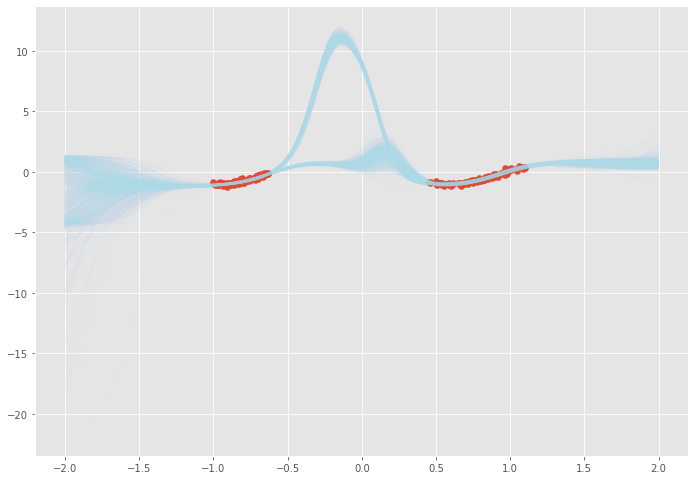

In [105]:
x_test = torch.linspace(-2.0, 2.0).unsqueeze(1).to(device)
fig, ax = plt.subplots()
fig.set_size_inches(11.7, 8.27)
plt.scatter(x_data.cpu(), y_data.cpu())
for _ in range(1000):
    mix.sample_parameters()

    y_test = mix.forward(x_test)
    plt.plot(x_test.detach().cpu().numpy(), y_test.squeeze(0).detach().cpu().numpy(), alpha=0.05, linewidth=1, color='lightblue')

In [100]:
x_test.shape

torch.Size([100, 1])

In [94]:
y_test = mix.forward(x_test)

In [99]:
x_test.detach().cpu().numpy().shape

(100, 1)

In [97]:
y_test.squeeze(0).detach().cpu().numpy().shape

(200, 1)